# Figure 8: Contrail evolution in the jet and vortex phase

Note: before running this script, you need to run [figure_7.ipynb](figure_7.ipynb) to process the contrail labels into width evolution series (for which you need the full dataset downloaded). 

In [1]:
import os
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [2]:
input_dir = "../../data/contrail_evolution/annotations"

contrails = {}

for filename in os.listdir(input_dir):
    if filename.endswith(".json"):
        scene_id = filename.replace(".json", "")
        
        with open(os.path.join(input_dir, filename)) as f:
            data = json.load(f)

        # Convert lists back to numpy arrays where needed
        for key in ["x", "y", "distance", "width", "age"]:
            if key in data:
                data[key] = np.array(data[key])

        contrails[scene_id] = data

In [3]:
all_data = []

for d in contrails.values():
    icao_code = d["icao_code"]
    
    # Extract arrays
    age = d["age"]
    width = d["width"]

    df_tmp = pd.DataFrame({
        "age": pd.to_numeric(age, errors="coerce"),
        "width": pd.to_numeric(width, errors="coerce"),
    })
    # 1. Drop NaNs
    df_tmp = df_tmp.dropna(subset=["width"])

    # If nothing left, skip
    if df_tmp.empty:
        continue

    df_tmp["age"] = df_tmp["age"].astype(int)
    df_tmp["width"] = df_tmp["width"].astype(float)

    # 2. Group by age (in case of duplicates) and take mean
    df_tmp = df_tmp.groupby("age", as_index=False).mean()

    # 3. Create full 1-second age grid
    age_full = np.arange(1, df_tmp["age"].max() + 1)

    # 4. Reindex and interpolate
    df_tmp = (
        df_tmp
        .set_index("age")
        .reindex(age_full)
        .interpolate(method="linear")
        .reset_index()
        .rename(columns={"index": "age"})
    )
    df_tmp["icao_code"] = icao_code  # keep icao_code for plotting
    df_tmp["scene_id"] = d["scene_id"]
    all_data.append(df_tmp)

# 5. Combine all contrails
df_all = pd.concat(all_data, ignore_index=True)
df_all = df_all.dropna(subset=["width"])
# Map ICAO to categories
def map_category(code):
    if code.startswith("A33"):
        return "A330"
    elif code.startswith("A34"):
        return "A340"
    else:
        return "Other"

df_all["category"] = df_all["icao_code"].apply(map_category)

/var/folders/zt/t69lkpcs0mz7l5vz3jt_48ldzb8s6f/T/ipykernel_88728/3085942042.py:119: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


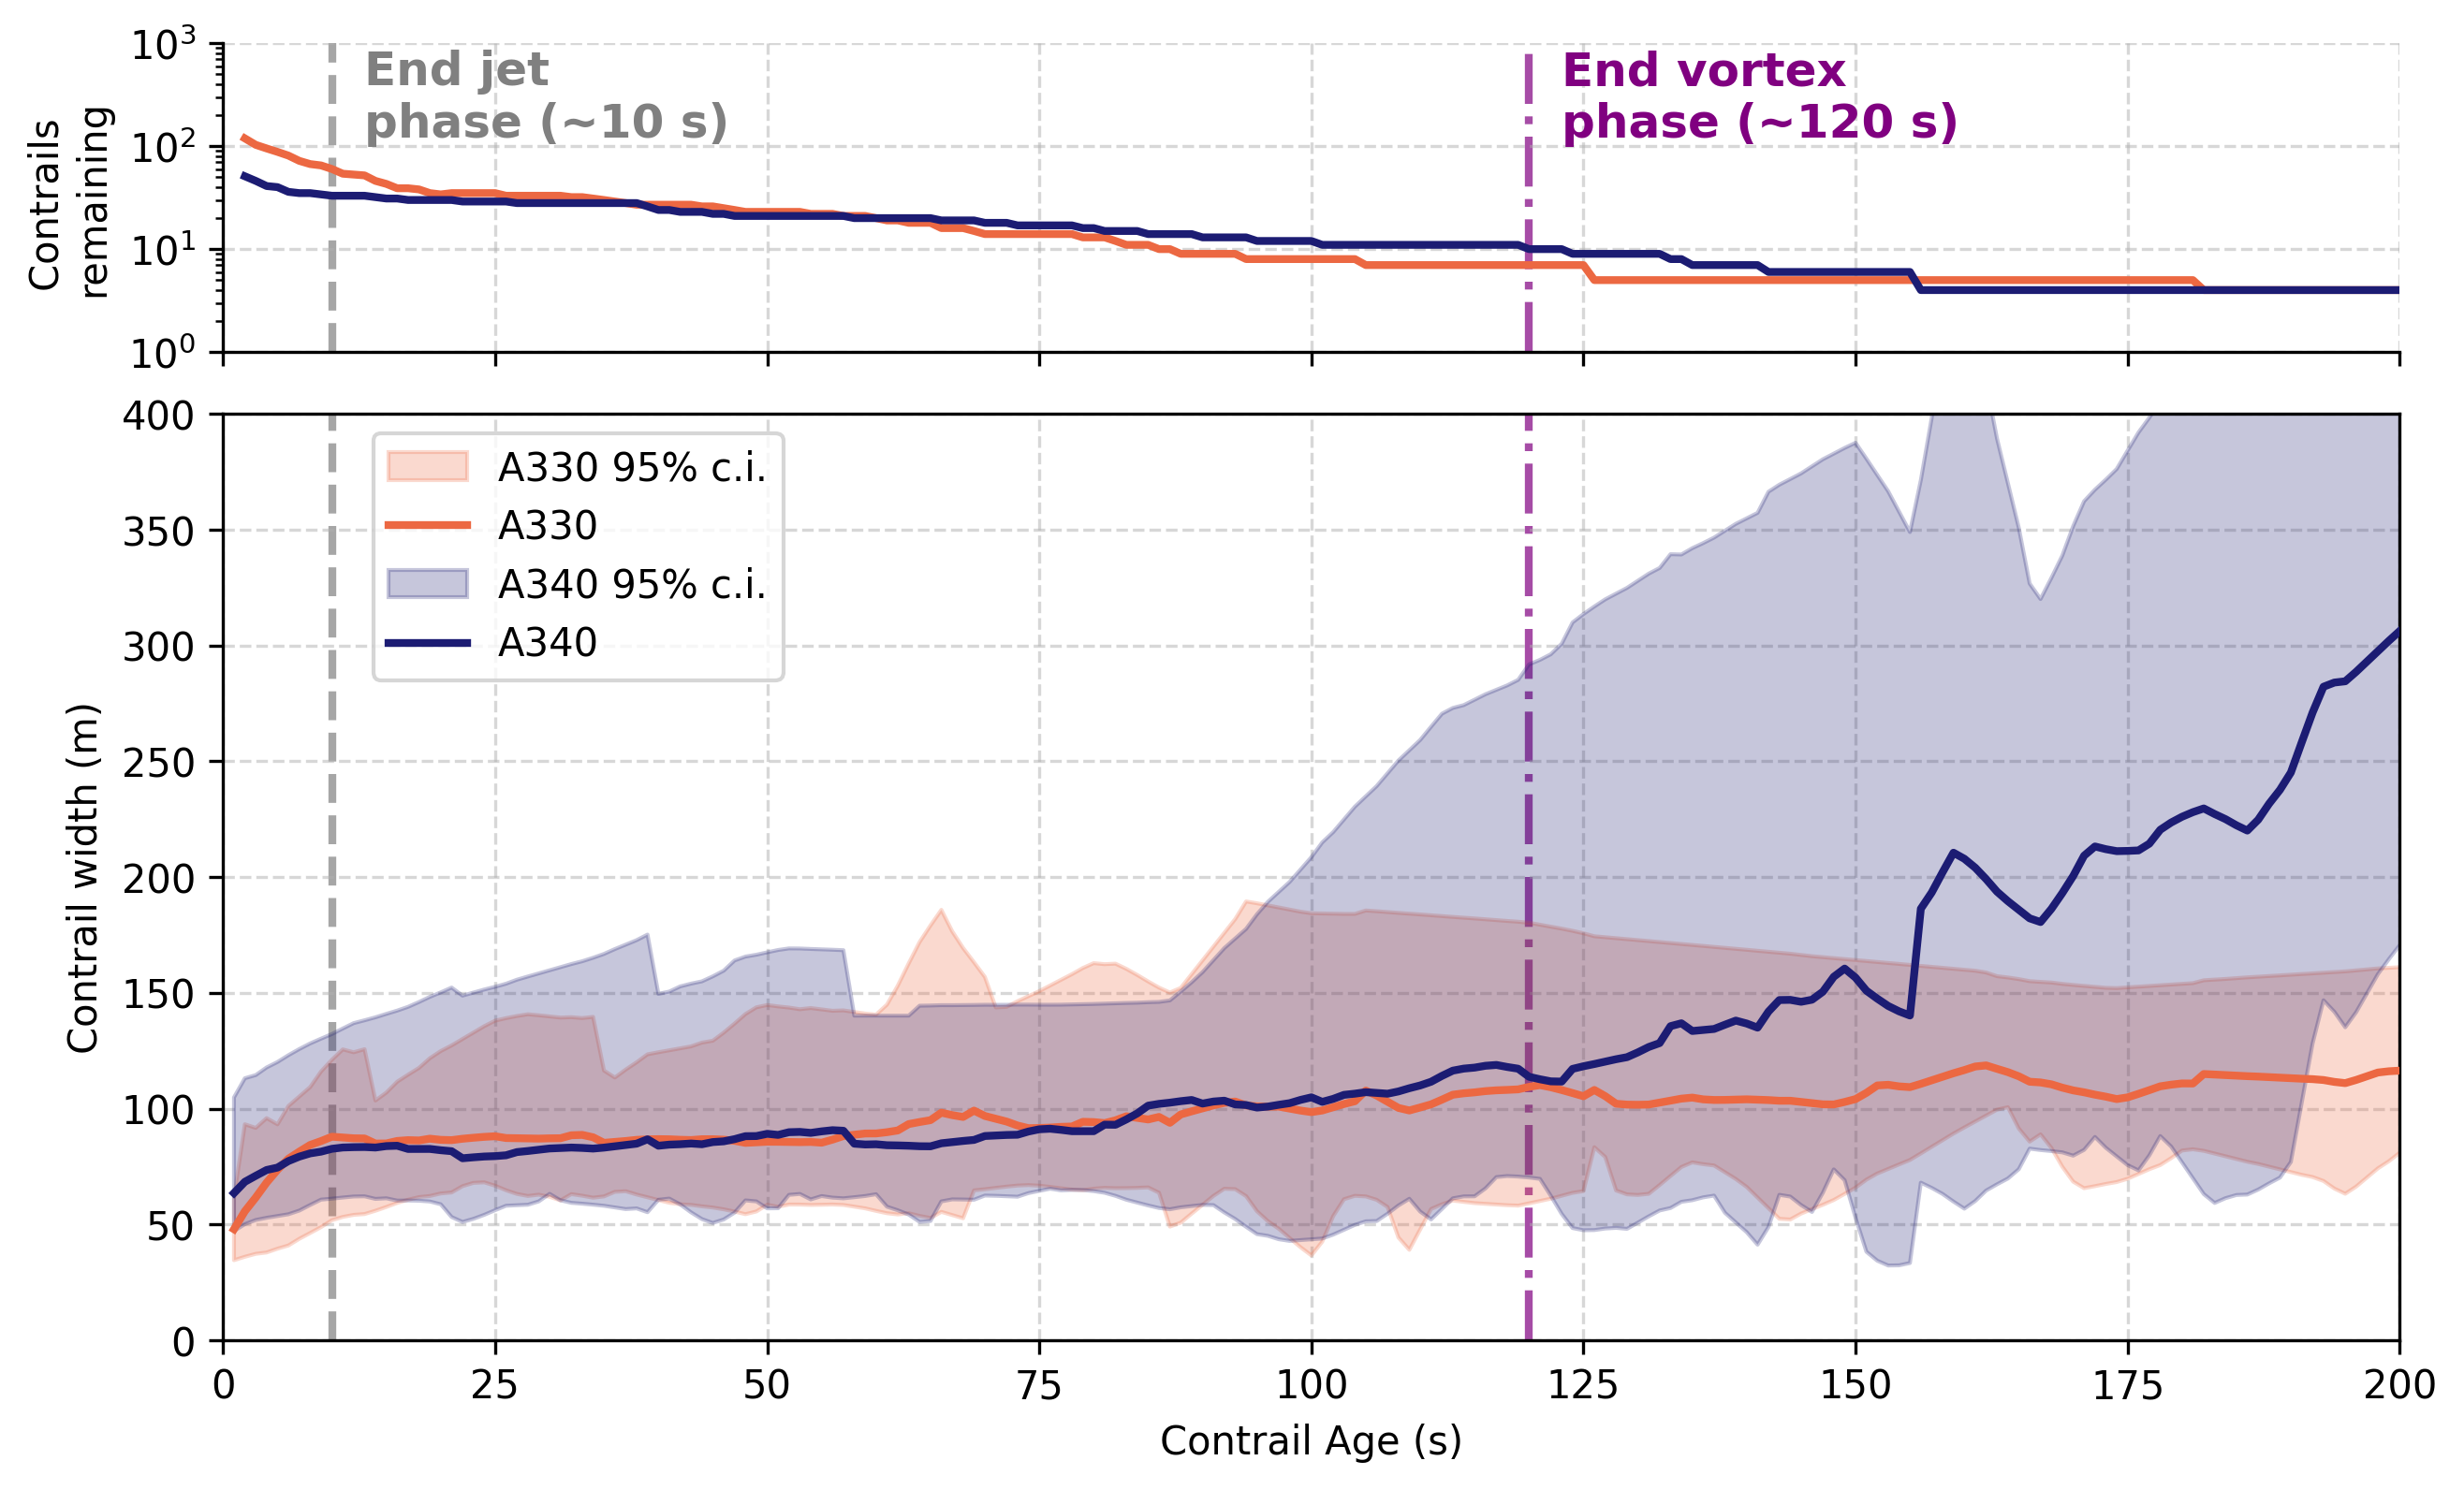

In [4]:
scene_max_age = (
    df_all.groupby("scene_id")["age"]
    .max()
)

norm = mcolors.Normalize(
    vmin=scene_max_age.min(),
    vmax=scene_max_age.max()
)
cmap = cm.viridis

# Create figure with two vertically stacked axes
fig, (ax_top, ax_main) = plt.subplots(
    2, 1,
    figsize=(10, 6),
    dpi=300,
    sharex=True,
    gridspec_kw={"height_ratios": [1, 3], "hspace": 0.1}
)

# Top panel: number of unique scene_id per second by type
for cat, color in zip(["A330", "A340"], ["#ec6842", "#1c1c73"]):
    scene_counts = (
        df_all[
            (df_all["category"] == cat) &
            (df_all["age"] >= 2)
        ]
        .groupby("age")["scene_id"]
        .nunique()
        .reset_index(name="n_scenes")
    )
    ax_top.plot(
        scene_counts["age"],
        scene_counts["n_scenes"],
        label=cat,
        linewidth=2,
        color=color
    )

# Reference lines
ax_top.axvline(10, color='grey', linestyle='--',
                alpha=0.7, linewidth=2, zorder=1)
ax_top.axvline(120, color='purple', linestyle='-.',
                alpha=0.7, linewidth=2, zorder=1)
ax_top.set_ylabel("Contrails \nremaining")
ax_top.grid(True, linestyle="--", alpha=0.5)
ax_top.tick_params(labelbottom=False)
ax_top.set_yscale("log")
ax_top.set_ylim(1, 1000)

# Main panel: width statistics (unchanged)
for cat, color in zip(["A330", "A340"], ["#ec6842", "#1c1c73"]):
    df_cat = df_all[df_all["category"] == cat]

    df_stats = df_cat.groupby("age")["width"].agg([
        ('mean_width', 'mean'),
        ('p5_width', lambda x: np.percentile(x, 2.5)),
        ('p95_width', lambda x: np.percentile(x, 97.5))
    ]).reset_index()

    ax_main.fill_between(
        df_stats['age'],
        df_stats['p5_width'],
        df_stats['p95_width'],
        alpha=0.25,
        label=f'{cat} 95% c.i.',
        zorder=2,
        color=color
    )

    ax_main.plot(
        df_stats['age'],
        df_stats['mean_width'],
        linewidth=2,
        label=f'{cat}',
        zorder=4,
        color=color
    )

# Reference lines
ax_main.axvline(10, color='grey', linestyle='--', alpha=0.7, linewidth=2, zorder=1)
ax_main.axvline(120, color='purple', linestyle='-.', alpha=0.7, linewidth=2, zorder=1)

ax_main.set_xlim(0, 200)
ax_main.set_ylim(0, 400)
ax_main.set_xlabel('Contrail Age (s)')
ax_main.set_ylabel('Contrail width (m)')
ax_main.legend(
    loc='upper left',              # reference point of the legend box
    bbox_to_anchor=(0.06, 1.),      # x, y in axes fraction (0=left/bottom, 1=top/right)
    frameon=True
)
ax_main.grid(True, linestyle='--', alpha=0.5)

ax_top.spines["top"].set_visible(False)
ax_top.spines["right"].set_visible(False)

# Add annotations at y=100
ax_top.text(
    13, 100, "End jet \nphase (~10 s)",
    color='grey',
    fontsize=12,
    fontweight='bold',
    ha='left',
    va='bottom',
    rotation=0
)

ax_top.text(
    123, 100, "End vortex \nphase (~120 s)",
    color='purple',
    fontsize=12,
    fontweight='bold',
    ha='left',
    va='bottom',
    rotation=0
)

plt.tight_layout()
plt.savefig("figures/fig08.png", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()